In [2]:
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np


In [3]:
from qiskit_aer.primitives import SamplerV2 as Sampler

In [4]:
import matplotlib.pyplot as plt
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

In [5]:
from itertools import combinations, cycle
coeff_dict  = {}

def array_k1(num_qubits):  #assuming num_qubits is even
    array_k = []
    m = num_qubits/2
    if (m)%2!=0: #replace with m-1 for previous results
        for j in range(-int((m)//2),int((m)//2) + 1): #replace with m-1 for previous results
            array_k.append(2*np.pi*j/num_qubits)
    else:
        for j in range(-int((m)//2),int((m)//2)):
            array_k.append(2*np.pi*j/num_qubits)
    return array_k


def recursive_nested(l,num_qubits,coeff_array,coeff = 1,bitstr=''):

    m = int(num_qubits/2) # taking always even number of qubits

    #coeff_dict_2 = {}
    if l==m-1: # m-1, but we start with 0 indexing
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                coeff = coeff*coeff_array[l,i]
                bitstr = bitstr + f'{i}'
                bitstr_sorted = sort_bitstr(bitstr) #to sort the string first
                perm = perm_str2(bitstr,bitstr_sorted) # to compare hamming distance
                if bitstr_sorted in coeff_dict.keys():
                    coeff_dict[bitstr_sorted]+=coeff*perm
                else:
                    coeff_dict[bitstr_sorted] = coeff*perm
            bitstr = bitstr_copy
            coeff = coeff_copy
    if l!=m-1:
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                #print(coeff)
                coeff = coeff*coeff_array[l,i]
                bitstr += str(i)
                recursive_nested(l+1,num_qubits,coeff_array,coeff,bitstr)
            bitstr = bitstr_copy
            coeff = coeff_copy

    return coeff_dict

def sort_bitstr(bitstr):
    bit_array = []
    for i in bitstr:
        bit_array.append(i)
    #print(bit_array)
    bitstr_sorted = ''
    for i in range(len(bit_array)):
        bit_array[i] = int(bit_array[i])
    bit_array.sort()
    #print(bit_array)
    for i in bit_array:
        #print(i,str(i))
        bitstr_sorted += str(i)
        #print(bitstr_sorted)

    return bitstr_sorted

def hammingDist(str1, str2): 
    i = 0
    count = 0
  
    while(i < len(str1)): 
        if(str1[i] != str2[i]): 
            count += 1
        i += 1
    return count 

def perm_str2(cmpr,word):

   #  word = 'eyssaasse' base string
   # cmpr = 'seasysaes'  a string to find number of swaps from the base string
    swaps = 0

    # 1)
    chars = {c: [] for c in word}
    [chars[c].append(i) for i, c in enumerate(word)]
    for k in chars.keys():
        chars[k] = cycle(chars[k])

    # 2)
    idxs = [next(chars[c]) for c in cmpr]

    # 3)
    for cmb in combinations(idxs, 2):
        if cmb[0] > cmb[1]:
            swaps += 1

    #print(swaps)
    if swaps%2 == 0:
        return 1
    else:
        return -1


In [6]:
#Let us first initialize the circuit and the state

def fermi_state(num_qubits): #of the form num_qubits = 2*odd number


    coeff_dict.clear()
    m = int(num_qubits/2)
    coeff_array = []
    array_k = array_k1(num_qubits)
    for k in array_k:
        pos_list = []
        for x in range(num_qubits):
            pos_list.append(np.exp(-1j*k*x))
        coeff_array.append(pos_list)

    coeff_array = np.array(coeff_array)

    #print(coeff_array)

    coeff_dict_2 = recursive_nested(0,num_qubits,coeff_array)
    #print(coeff_dict_2)
    bitstr_dict = {}
    for bstr in coeff_dict_2.keys():
        vac_str = ''
        num_list = []
        for k in range(m):
            num_list.append(int(bstr[k]))

        for i in range(num_qubits):
            if i in num_list:
                vac_str += '1'
            else:
                vac_str += '0'
        bitstr_dict[vac_str] = coeff_dict[bstr]

    #print(bitstr_dict)
    

    fermi_state = Statevector([0]*(2**num_qubits))

    for bstr in bitstr_dict.keys():
        fermi_state += Statevector.from_label(bstr)*bitstr_dict[bstr]

    val_array = []
    for i in bitstr_dict.values():
        val_array.append(i)
    np_array = np.array(val_array)
    #print(np_array)
    #print(np.linalg.norm(np_array))
    
    fermi_state = fermi_state/np.linalg.norm(val_array)
    #print(fermi_state)
    fermi_state.is_valid()

    return fermi_state


#print(fermi_state(6))

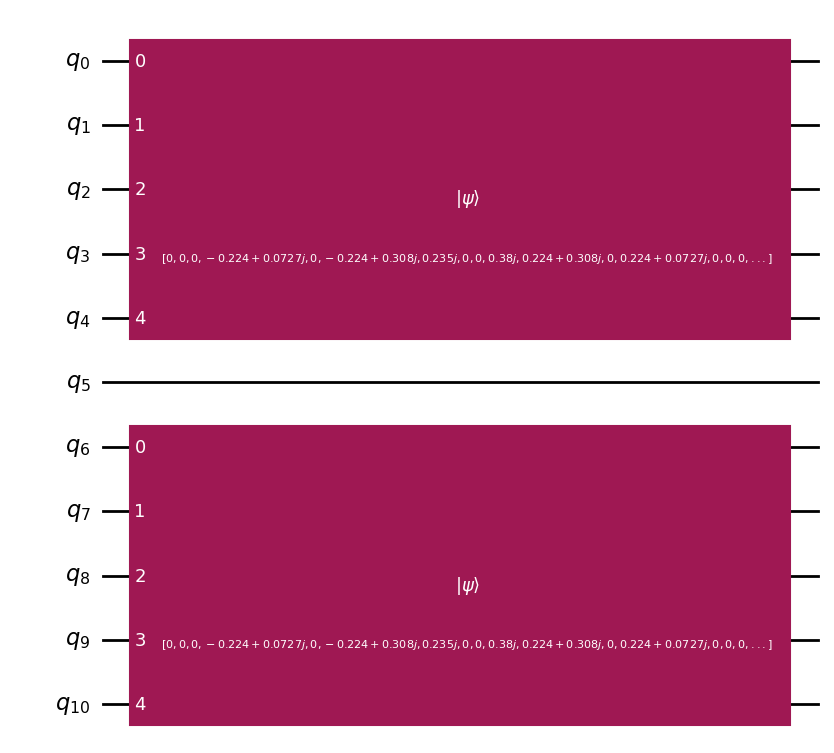

In [7]:
# Now we initialize the circuit with the fermi states for both up and down spin chains
N = 5 #number of sites
num_qubits = 2*N + 1
def fermi_state_circuit(N,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_up = fermi_state(N)
    fermi_state_down = fermi_state(N)
    qc.initialize(fermi_state_up,range(N))
    qc.initialize(fermi_state_down,range(N+1,2*N+1))
    return qc

qc = fermi_state_circuit(N)
qc.draw(output='mpl')


In [8]:
#Let us utilize other state preparation methods to compare the results

def fermion_state(N,pos_list,num_cl_bits = 0):
    qc = QuantumCircuit(2*N+1,num_cl_bits)
    for i in range(2*N+1):
        if i in pos_list or i==N:
            continue
        else:
            qc.x(i)
    return qc

In [9]:
list(range(N)) + list(range(N+1,2*N+1))

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

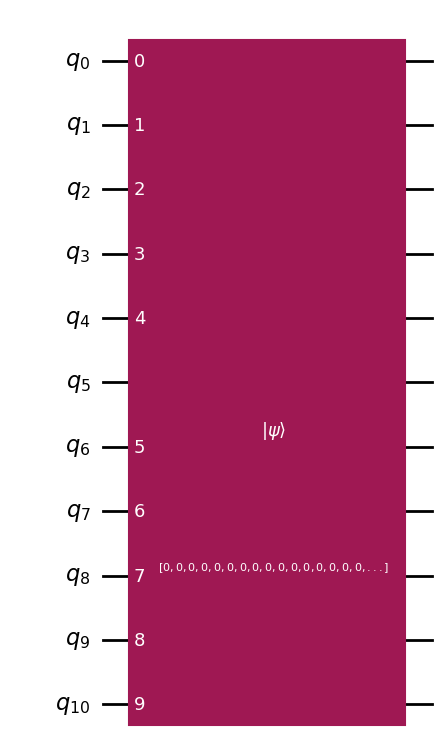

In [10]:
def fermi_state_circuit2(N,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_all = fermi_state(2*N)
    
    qc.initialize(fermi_state_all,list(range(N)) + list(range(N+1,2*N+1)))
    return qc

qc2 = fermi_state_circuit2(N)
qc2.draw(output='mpl')

In [11]:
from qiskit.quantum_info import Operator

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def add_fsim_half(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

def add_fsim_inv_half(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)

    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

In [12]:
trotter_steps = 2
angles = [np.pi/4,0,0]

In [22]:
#Now we add the entire kondo circuit

# Let us use the direct 8 by 8 unitary now for the problem
import math as m
import cmath as cm

def kondo_unitary(theta_k,theta_z):

    l1 = cm.exp(1j*theta_z/2)
    l2 = cm.exp(-1j*theta_z/2)
    c1 = m.cos(theta_k)
    s1 = m.sin(theta_k)

    a = m.cos(np.sqrt(2)*theta_k) - (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    a_dag = m.cos(np.sqrt(2)*theta_k) + (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    b = (-1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    c = cm.exp(-1j*theta_k) 
    d = cm.exp(1j*theta_k)

    """kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,l1,0,0,0,0,0],
                          [0,0,0,c1*l2,1j*l2*s1,0,0,0],
                          [0,0,0,1j*l2*s1,c1*l2,0,0,0],
                          [0,0,0,0,0,l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])"""
    kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,a,0,0,0,0,b,0],
                          [0,0,1,0,0,0,0,0],
                          [0,0,0,d,0,0,0,0],
                          [0,0,0,0,c,0,0,0],
                          [0,0,0,0,0,1,0,0],
                          [0,b,0,0,0,0,a_dag,0],
                          [0,0,0,0,0,0,0,1]])
    
    kondo_unitary_2 = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,c1*l1,0,0,1j*s1*l1,0,0],
                          [0,0,0,l2,0,0,0,0],
                          [0,0,0,0,l2,0,0,0],
                          [0,0,1j*s1*l1,0,0,c1*l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    
    return kondo_unitary_2

def circuit_3(N, pos_list, trotter_steps,angles = [0,0,0],theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False, save = False):
    if num_cl_bits == 0:
        qc = fermi_state_circuit(N)
    else:
        qc = fermi_state_circuit(N,num_cl_bits)
    qc.x(N)
    qc.barrier()
    
    c = num_qubits//2
    for trotter_step in range(trotter_steps):
        add_fsim_half(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    if save == True:
        qc.save_statevector()
    #qc.save_statevector()  remove save for changing to operator
    return qc

qc = circuit_3(N,[2*N],trotter_steps,angles,trotter_barriers = True)
#qc.draw(output = 'mpl')

## Check whether Kondo Part is preserving spin....

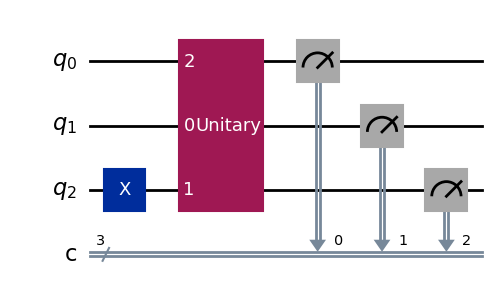

In [14]:
qc_check = QuantumCircuit(3,3)
qc_check.x([2])
qc_check.unitary(kondo_unitary(np.pi/6,np.pi/6),[1,2,0])
qc_check.measure([0,1,2],[0,1,2])
qc_check.draw(output = 'mpl')

In [15]:
sampler = Sampler()
job_exp = sampler.run([qc_check,qc_check],shots = 1000)
result_check = job_exp.result()


In [16]:
result_check[0].data.c.get_counts()

{'011': 241, '100': 759}

## S_z measurement of impurity and leads and some basic checks


In [23]:
max_trotter_steps = 20  #int (10/theta_k)
measured_bits =list(range(2*N + 1))
theta_k = np.pi/6  #To check whether if kondo circuit is messing up the spin conservation (use corrected one)
theta_z = -theta_k  #Can be equal to theta_k as well, depending on written Hamiltonian form

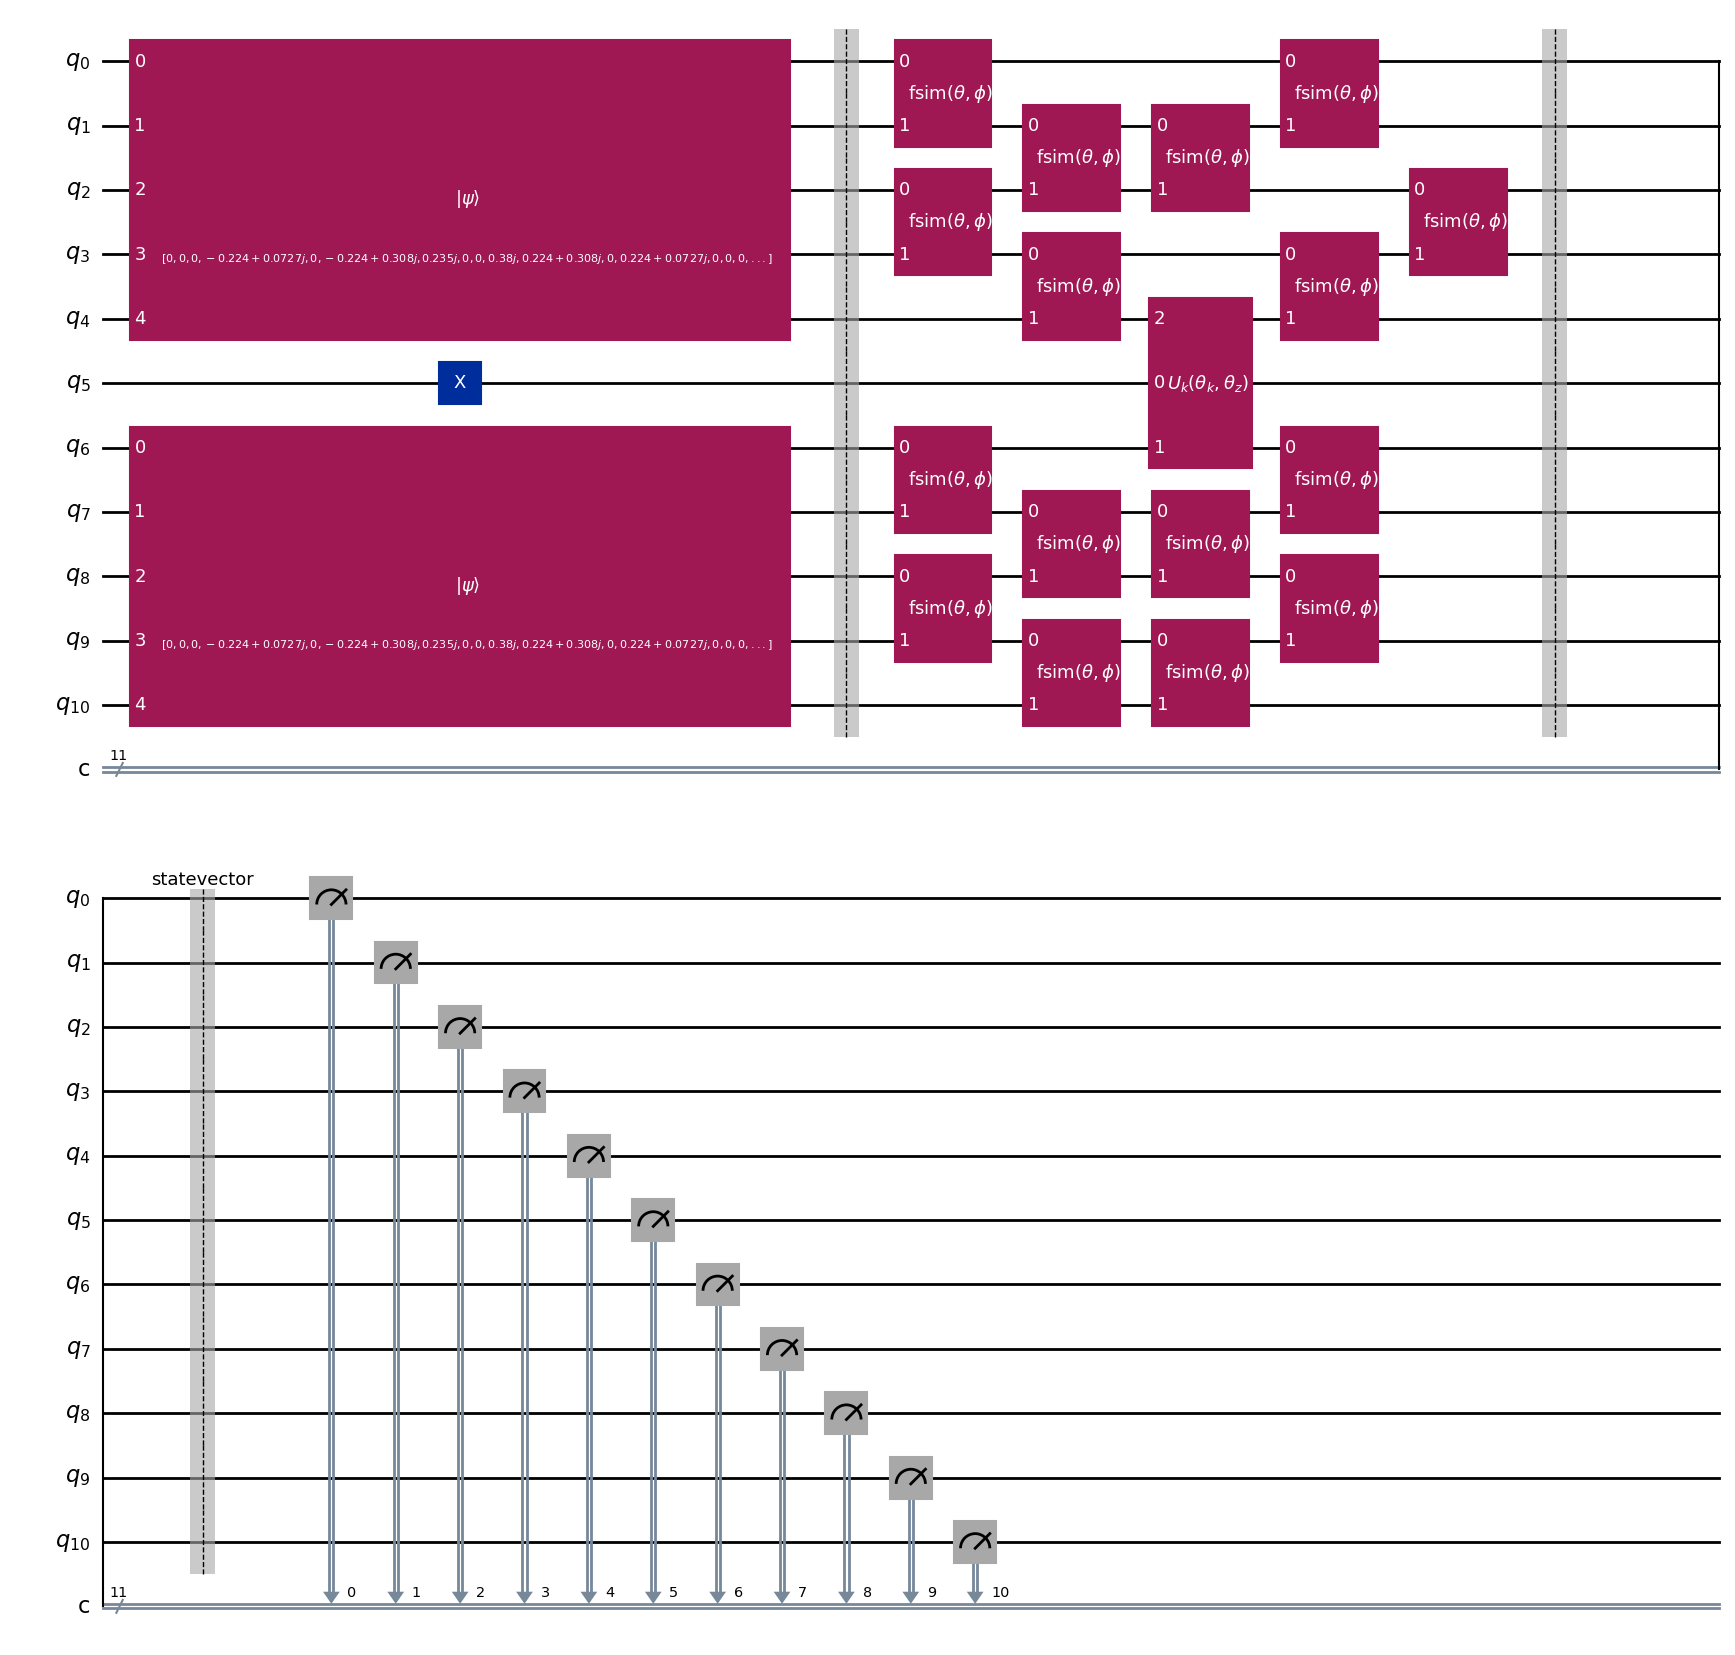

In [24]:


qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = circuit_3(N,[0,1,2*N], trotter_steps, angles, num_cl_bits = len(measured_bits),theta_k=theta_k,theta_z=theta_z, trotter_barriers = True, save = True)
    qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)

qc_list[1].draw(output = "mpl")

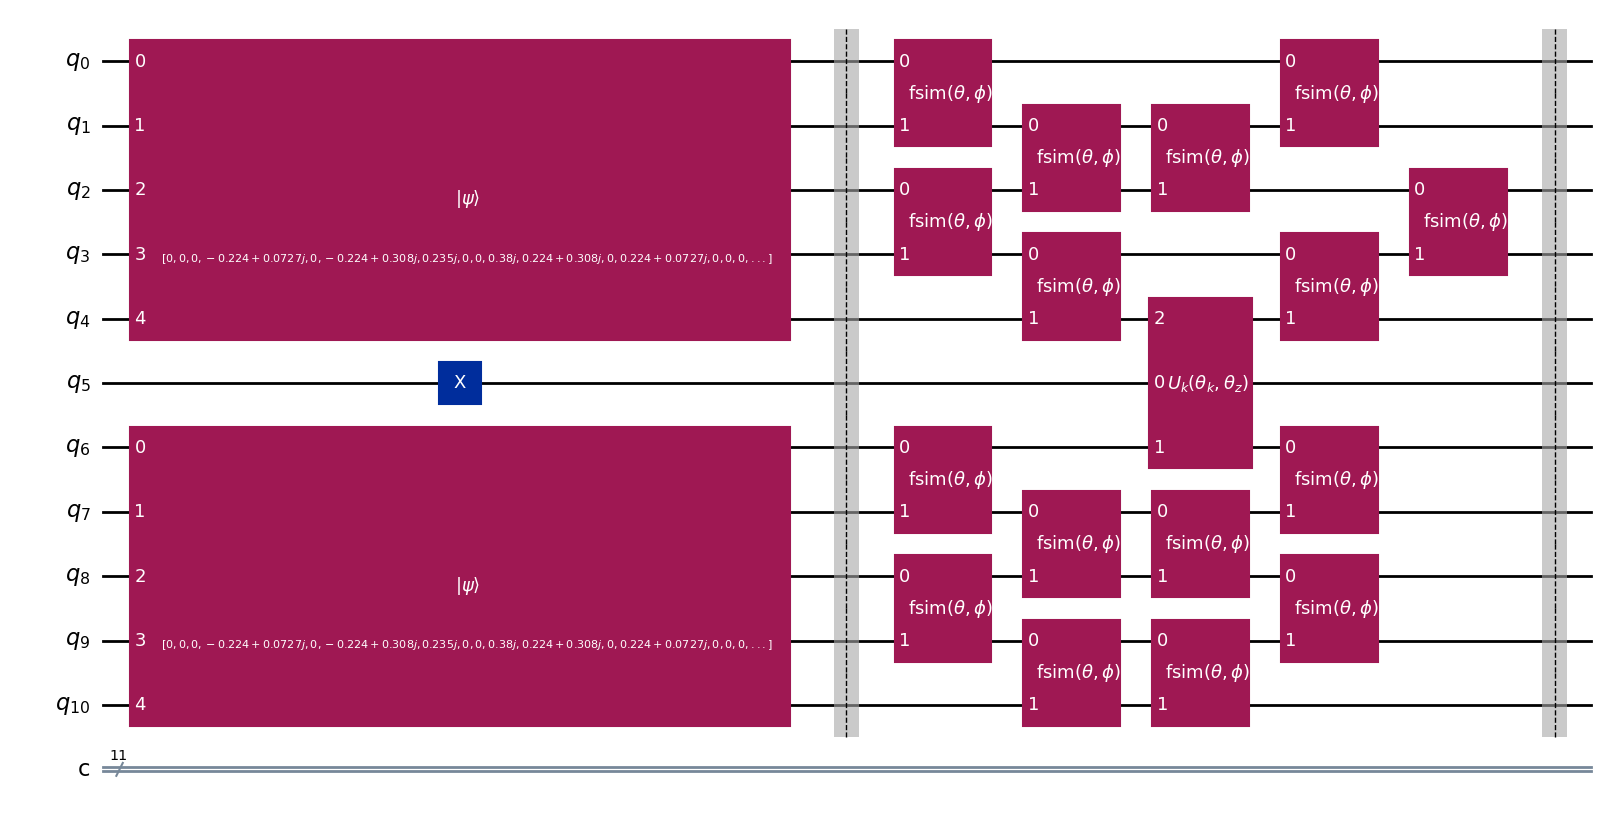

In [25]:
qc_list2 = []
for trotter_steps in range(max_trotter_steps):
    qc = circuit_3(N,[0,1,2*N], trotter_steps, angles, num_cl_bits = len(measured_bits),theta_k=theta_k,theta_z=theta_z, trotter_barriers = True, save = False)
    #qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list2.append(qc)

qc_list2[1].draw(output = "mpl")


In [26]:


imp_observables = [SparsePauliOp('I'*N + 'Z' + 'I'*N)]*max_trotter_steps
lead_1_observables = [SparsePauliOp('I'*(N-1) + 'Z' + 'I'*(N+1))]*max_trotter_steps
lead_2_observables = [SparsePauliOp('I'*(N+1) + 'Z' + 'I'*(N-1))]*max_trotter_steps

both_leads_observables = [SparsePauliOp('I'*(N-1) + 'ZZ' + 'I'*N)]*max_trotter_steps

estimator =  Estimator(approximation=True)
job_1 = estimator.run(qc_list,imp_observables,shots = None)
job_2 = estimator.run(qc_list,lead_1_observables,shots = None)
job_3 = estimator.run(qc_list,lead_2_observables,shots = None)
job_4 = estimator.run(qc_list,both_leads_observables,shots = None)
expectation_list_1 = list(job_1.result().values)
expectation_list_2 = list(job_2.result().values)
expectation_list_3 = list(job_3.result().values)
expectation_list_4 = list(job_4.result().values)




In [27]:
sampler = Sampler()
job = sampler.run(qc_list,shots = 1000)
result = job.result()


In [28]:
result[4].data.c

BitArray(<shape=(), num_shots=1000, num_bits=11>)

In [29]:
imp_observable = SparsePauliOp('I'*N + 'Z' + 'I'*N)
print(expectation_list_1)

[-1.0000000000000002, -0.9706211070068494, -0.9594254367692416, -0.9051437279867597, -0.636218816044398, -0.39308506413057764, -0.4466523850677573, -0.5245865740265305, -0.42063359160861397, -0.035123360430245526, 0.1676392589370867, -0.13486324003119954, -0.4072732767633342, -0.45948136937398926, -0.42925349810128927, -0.4431731141641749, -0.634259463154512, -0.7272018744419683, -0.7958111018522662, -0.8144865964321046]


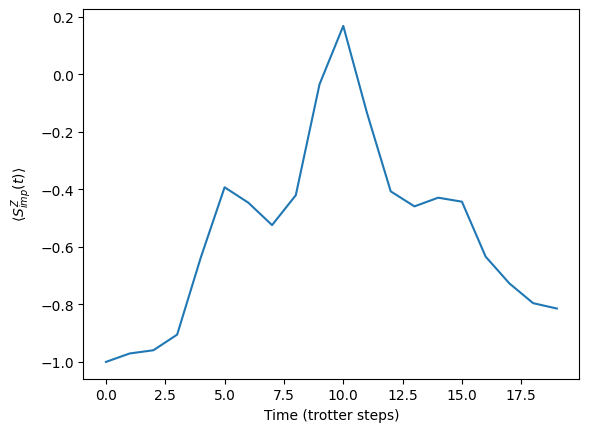

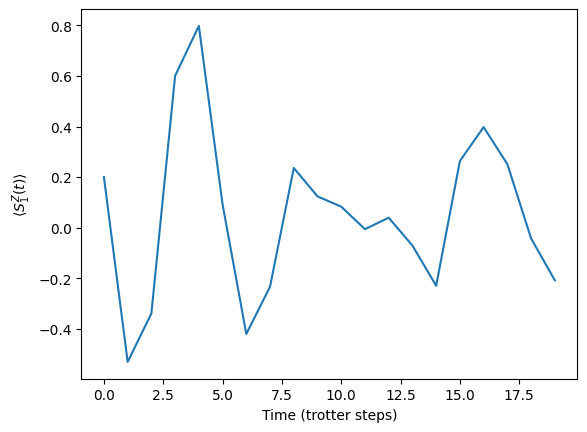

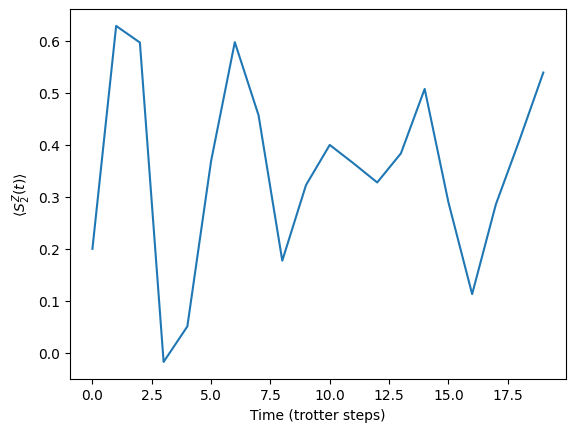

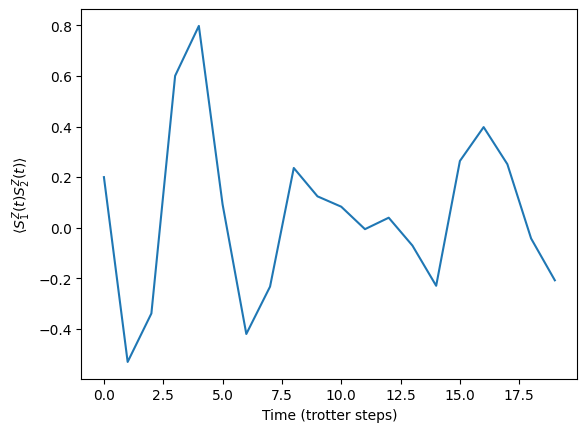

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(max_trotter_steps),expectation_list_1,label = 'Impurity')
plt.xlabel('Time (trotter steps)')
plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
plt.show()

plt.plot(range(max_trotter_steps),expectation_list_2,label = 'Lead 1')
plt.xlabel('Time (trotter steps)')
plt.ylabel(r'$\langle S^Z_{1}(t) \rangle$')
plt.show()

plt.plot(range(max_trotter_steps),expectation_list_3,label = 'Lead 3')
plt.xlabel('Time (trotter steps)')
plt.ylabel(r'$\langle S^Z_{2}(t) \rangle$')
plt.show()

plt.plot(range(max_trotter_steps),expectation_list_2,label = 'Combined leads')
plt.xlabel('Time (trotter steps)')
plt.ylabel(r'$\langle S^Z_{1}(t)S^Z_{2}(t) \rangle$')
plt.show()



In [31]:
def total_ferm_mag(bitstr_dict):
    total_ferm_mag = 0
    for bstr in bitstr_dict.keys():
        #print(bstr)
        #print(bstr[N+1:].count('0'))
        #print(bstr[:N].count('0'))
        total_ferm_mag += (bstr[0:N].count('0') - bstr[N+1:].count('0'))*bitstr_dict[bstr]
    return total_ferm_mag

def check_mag(qc_list):
    sampler = Sampler()
    job = sampler.run(qc_list,shots = 1000)
    result = job.result()
    ferm_mag_arr = []
    for i in range(len(qc_list)):
        ferm_mag_arr.append(total_ferm_mag(result[i].data.c.get_counts())/1000)

    ferm_mag_arr = np.array(ferm_mag_arr)
    final_ferm_mag = ferm_mag_arr + expectation_list_1
    print(final_ferm_mag)
    
    plt.plot(range(max_trotter_steps),final_ferm_mag, label = 'Total magnetization')
    #plt.plot(range(max_trotter_steps),expectation_list_1,label = 'Impurity magnetization')
    plt.xlabel('Time (trotter steps)')
    plt.ylabel(r'Magnetization values')
    plt.legend()

[-1.         -1.01262111 -0.99542544 -1.00714373 -1.00821882 -1.03308506
 -1.00265239 -0.97458657 -1.03263359 -0.96712336 -0.95236074 -1.00886324
 -1.03727328 -0.98548137 -1.0012535  -0.98917311 -0.97825946 -0.96320187
 -1.0018111  -1.0044866 ]


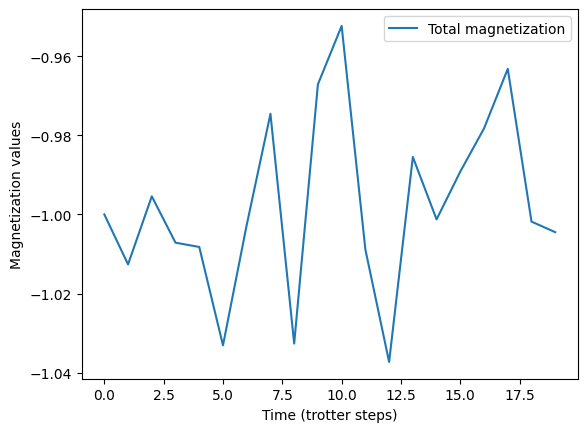

In [32]:
check_mag(qc_list)

In [33]:
from qiskit.quantum_info import Operator

In [34]:
mr= np.array(Operator.from_circuit(qc_list2[0]))
print(mr)
mr.size

np.allclose(np.eye(len(mr)), m.dot(mr.T.conj()))




QiskitError: 'Cannot apply Operation: reset'

In [35]:


def total_herm_check(qc_list, theta, theta_k):
    H_t = 0
    H_k = 0
    for i in range(2*N):
        if i==N-1 or i==N:
            continue
        else:
            H_t += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(2*N-i-1)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(2*N-i-1)))
    H_k = -theta_k*(SparsePauliOp('I'*(N-1) + 'XXX' + 'I'*(N-1))+SparsePauliOp('I'*(N-1) + 'YXY' + 'I'*(N-1)) + SparsePauliOp('I'*(N-1) + 'XYY' + 'I'*(N-1))- SparsePauliOp('I'*(N-1) + 'YYX' + 'I'*(N-1))+ SparsePauliOp('I'*(N) + 'ZZ' + 'I'*(N-1)) - SparsePauliOp('I'*(N-1) + 'ZZ' + 'I'*(N)))
    h_analytical = [H_t + H_k]*max_trotter_steps
    print("Operator obtained from circuit")
    #h_fromcirc = [Operator.from_circuit(qc) for qc in qc_list]
    job_analytical = estimator.run(qc_list,h_analytical,shots = None)
    print("Analytical run complete")
    #job_fromcirc = estimator.run(qc_list,h_fromcirc,shots = None)
    print("Circuit run complete")

    h_values1 = list(job_analytical.result().values)
    #h_values2 = list(job_fromcirc.result().values)

    print("Plotting the results....")

    plt.plot(range(max_trotter_steps),h_values1,label = 'Total Hamiltonian analytical')
    #plt.plot(range(max_trotter_steps),h_values2,label = 'Total Hamiltonian from circuit')
    plt.xlabel('Time (trotter steps)')
    plt.ylabel(r'$\langle H(t) \rangle$')
    plt.legend()


    

Operator obtained from circuit
Analytical run complete
Circuit run complete
Plotting the results....


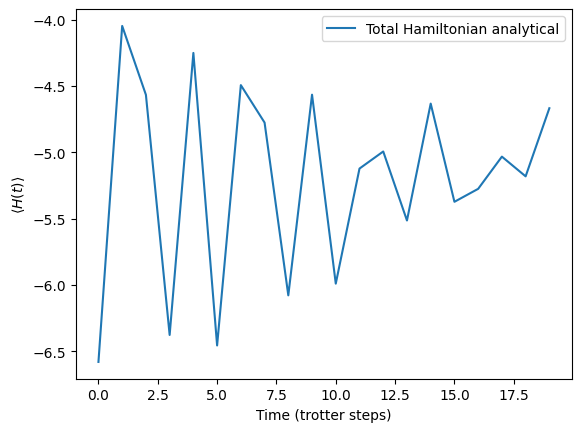

In [36]:
total_herm_check(qc_list2,angles[0],theta_k)

In [37]:
#Let us understand if numerics give us any recurrence times

from scipy.signal import find_peaks
from numpy.fft import fft, ifft

peaks, _ = find_peaks(expectation_list_1)
#print(peaks)

fft1 = fft(expectation_list_1)
fft2 = fft(expectation_list_2)
fft3 = fft(expectation_list_3)
fft4 = fft(expectation_list_4)

print(fft1)

[-10.96965434+0.00000000e+00j  -3.95691379+2.86401919e-01j
   0.16893522+3.91538158e-01j  -0.89465853+3.27752342e-01j
   1.27048447+2.80028255e-01j  -0.63488198-2.36740477e-01j
  -0.08213049+7.40263214e-02j  -0.22906718+1.38835303e-02j
   0.0427954 +1.23888289e-01j  -0.1226748 +4.15341805e-02j
  -0.15412228-2.77555756e-17j  -0.1226748 -4.15341805e-02j
   0.0427954 -1.23888289e-01j  -0.22906718-1.38835303e-02j
  -0.08213049-7.40263214e-02j  -0.63488198+2.36740477e-01j
   1.27048447-2.80028255e-01j  -0.89465853-3.27752342e-01j
   0.16893522-3.91538158e-01j  -3.95691379-2.86401919e-01j]


Text(0, 0.5, 'Magnitude')

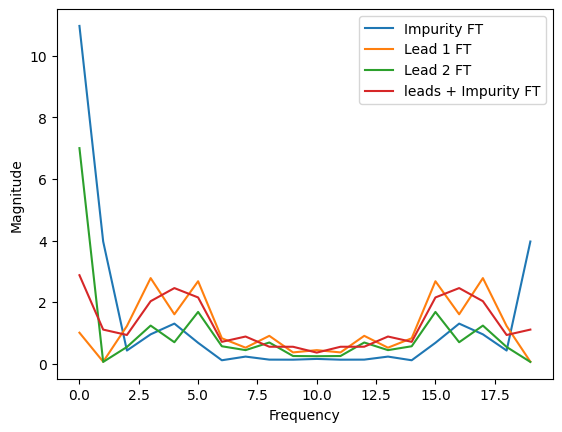

In [38]:
plt.plot(range(max_trotter_steps),np.abs(fft1),label = 'Impurity FT')
plt.plot(range(max_trotter_steps),np.abs(fft2),label = 'Lead 1 FT')
plt.plot(range(max_trotter_steps),np.abs(fft3),label = 'Lead 2 FT')
plt.plot(range(max_trotter_steps),np.abs(fft4),label = 'leads + Impurity FT')
plt.legend(loc = "upper right")
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

In [235]:
peaks, _ = find_peaks(np.abs(fft1))
print(peaks)

[ 8 12]


## Code for the four tests


In [39]:
## For magnetization on sites, we have to utilise the bitstring probabilities
from qiskit_aer.primitives import SamplerV2 as Sampler

def mag1calc(k,bitstr_dict):
    mag1 = 0
    for bstr in bitstr_dict.keys():
        if bstr[N-k] == bstr[N+k]:
            mag1+=0
        elif bstr[N-k] == '1' and bstr[N+k] == '0':
            mag1+=-1*bitstr_dict[bstr]
        elif bstr[N-k] == '0' and bstr[N+k] == '1':
            mag1+=1*bitstr_dict[bstr]
    return mag1





In [40]:
result[4].data.c.get_counts()

{'01100100110': 16,
 '00110110100': 61,
 '10110000100': 17,
 '10110010000': 20,
 '10100110100': 132,
 '10100101100': 82,
 '01010101100': 7,
 '00111000010': 5,
 '10100110001': 7,
 '00110110010': 16,
 '10100101010': 29,
 '01010110010': 6,
 '10010110100': 38,
 '11010010000': 2,
 '10110001000': 10,
 '10100110010': 42,
 '00101110100': 4,
 '01100100101': 1,
 '10010101100': 17,
 '01110010000': 19,
 '00110100110': 16,
 '01100110010': 19,
 '01100110100': 52,
 '10001110100': 1,
 '00101100110': 1,
 '00011110001': 2,
 '10010100110': 24,
 '10100100011': 12,
 '10110000010': 23,
 '01011000010': 1,
 '01101000010': 10,
 '10100100110': 67,
 '00110101100': 29,
 '01010100110': 11,
 '01001101010': 1,
 '10101000100': 10,
 '10010101010': 13,
 '10101000010': 18,
 '11010000010': 1,
 '01100101010': 4,
 '00101101100': 2,
 '01010101010': 7,
 '01011010000': 3,
 '10011000010': 6,
 '10010110010': 16,
 '01010110100': 18,
 '00110101010': 8,
 '10011010000': 2,
 '11100010000': 6,
 '01011000100': 1,
 '01101000100': 4,
 '

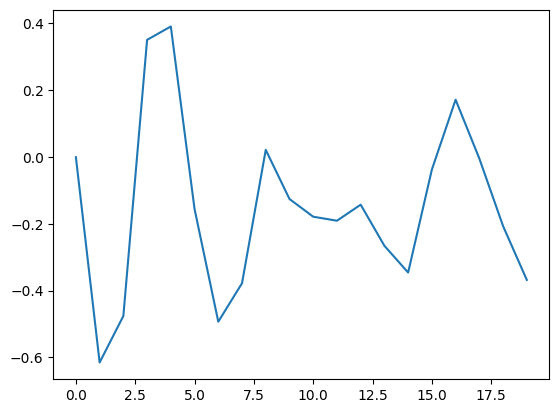

In [41]:
mag_array = []

for trotter_steps in range(max_trotter_steps):
    mag_1 = mag1calc(1,result[trotter_steps].data.c.get_counts())/1000
    mag_array.append(mag_1)

plt.plot(range(max_trotter_steps),mag_array)

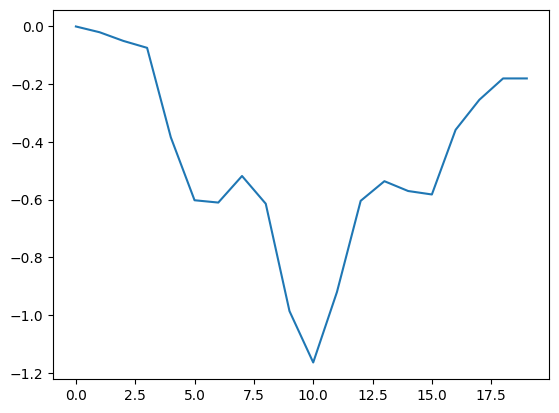

In [42]:


total_mag_array = []


for trotter_steps in range(max_trotter_steps):
    mag = total_ferm_mag(result[trotter_steps].data.c.get_counts())/1000
    total_mag_array.append(mag)

plt.plot(range(max_trotter_steps),total_mag_array)



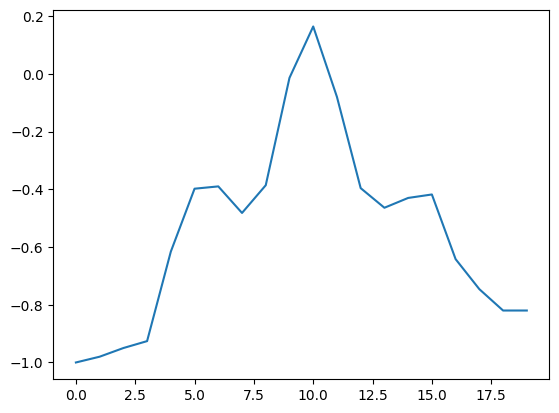

In [43]:
#Let's check the magnetization on impurity site

def impurity_mag(bitstr_dict):
    impurity_mag = 0
    for bstr in bitstr_dict.keys():
        if bstr[N] == '1':
            impurity_mag -= bitstr_dict[bstr]
        else:
            impurity_mag += bitstr_dict[bstr]
    return impurity_mag

impurity_mag_array = []

for trotter_steps in range(max_trotter_steps):
    mag = impurity_mag(result[trotter_steps].data.c.get_counts())/1000
    impurity_mag_array.append(mag)

plt.plot(range(max_trotter_steps),impurity_mag_array)

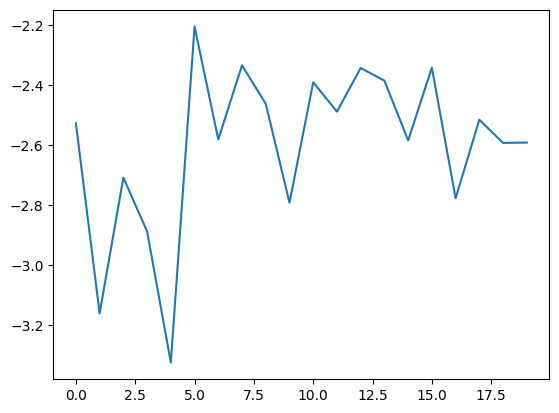

In [44]:
#Let's check the entanglement entropy
from qiskit.quantum_info import entropy

def entanglement_entropy(bitstr_dict):
    ent_entropy = 0
    for bstr in bitstr_dict.keys():
        ent_entropy += -1*bitstr_dict[bstr]*np.log(bitstr_dict[bstr])
    return ent_entropy

ent_array = []
for trotter_steps in range(max_trotter_steps):
    ent = entanglement_entropy(result[trotter_steps].data.c.get_counts())/1000
    ent_array.append(ent)

plt.plot(range(max_trotter_steps),ent_array)


##Entanglement measures: Negativity and C-SWAP


In [45]:
#The first step is to get a density matrix from the circuits

from qiskit.quantum_info import DensityMatrix
simulator_aer = AerSimulator()
def get_density_matrix(qc_list):
    density_matrix_list = []
    for qc in qc_list:
        qc_aer = transpile(qc, backend=simulator_aer)
        result = simulator_aer.run(qc_aer).result()

        state = result.get_statevector()
        print(state.is_valid())
        print(state)
        density_matrix = DensityMatrix(state)
        density_matrix_list.append(density_matrix)
    return density_matrix_list

density_matrix_list = get_density_matrix(qc_list)

True
Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
True
Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
True
Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
True
Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
True
Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
True
Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
True
Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
True
Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
True
Sta

In [46]:
density_matrix_arr = np.array(density_matrix_list[2])
print(np.count_nonzero(density_matrix_arr))
print(density_matrix_arr)

22500
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


In [47]:
def trace_norm(density_matrix):
    density_matrix = np.array(density_matrix)
    eigenvalues, eigenvectors = np.linalg.eig(density_matrix)
    sum = 0
    #print(eigenvalues)
    for i in eigenvalues:
        if i.real < 0:
            sum += i.real
    #print(sum)
    return abs(sum)
    

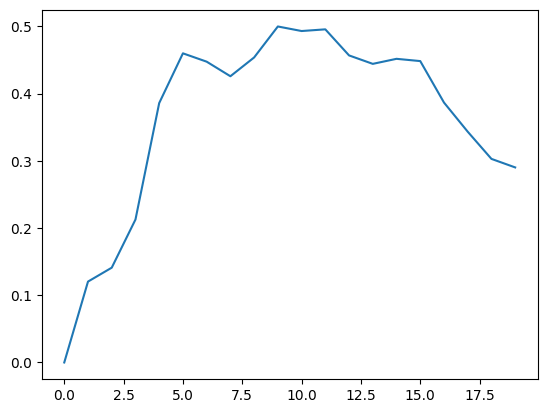

In [48]:
def negativity(density_matrix_list):
    neg_list = []
    for density_matrix in density_matrix_list:
        dm_pt = density_matrix.partial_transpose([N])
        neg = trace_norm(dm_pt)
        #print(neg)
        neg_list.append(neg.real)
    return neg_list

neg_list = negativity(density_matrix_list)

plt.plot(range(max_trotter_steps),neg_list)

In [49]:
from qiskit.quantum_info import partial_trace

dm_test = density_matrix_list[0]
qargs = list(range(N)) + list(range(N+1,2*N+1))
dm_test_pt = partial_trace(dm_test,qargs)

dm_test_dict = dm_test_pt.probabilities_dict()
print(dm_test_dict)


{'1': 1.0}


In [50]:
str1 = '0'
print(str1[-1])

0


In [61]:
from qiskit.quantum_info import purity

In [70]:
#The swap test circuit for two partially traced matrices will measure overlap between them, which is a non-linear operation that we want.
#from qiskit.quantum_info import partial_trace
def concurrence_circ(dm):
    qc = QuantumCircuit(3,1)
    dm_zero = DensityMatrix.from_label('0')
    dm_state1 = dm.tensor(dm) 
    dm_state = dm_zero.tensor(dm_state1)


    qc.h(0)
    qc.cswap(0,1,2)
    qc.h(0)

    dm_final = dm_state.evolve(qc)

    dm_dict = dm_final.probabilities_dict()
    return dm_dict

def dict_to_conc(dm_dict):
    conc = 0
    for key in dm_dict.keys():
        if key[-1] == '0':
            conc += dm_dict[key]
    return conc

def concurrence(density_matrix_list):
    concurrence_list = []
    qargs = list(range(N)) + list(range(N+1,2*N+1))
    for density_matrix in density_matrix_list:
        partial_dm = partial_trace(density_matrix,qargs)
        #print("Partial dm is:",partial_dm)
        #print("Purity is :", purity(partial_dm))
        #dm_dict = concurrence_circ(partial_dm)
        #tr_sq = dict_to_conc(dm_dict)
        #print("Valu of trace squared is:",tr_sq)
        c = purity(partial_dm).real
        if c>1:
            c = 1
            print("Purity is greater than 1,by a value of:",c-1)
        concurrence_list.append(np.sqrt(2*(1-c)))
    return concurrence_list





def swap_test_circuit(state):
    qc = QuantumCircuit(4*N+3,1)
    qc.initialize(state,range(1,2*N+2))
    qc.initialize(state,range(2*N+2,4*N+3))
    #dm_zero = DensityMatrix.from_label('0')
    #dm_state1 = dm.tensor(dm) 
    #dm_state = dm_zero.tensor(dm_state1)
    qc.h(0)
    qc.cswap(0,N+1,3*N+3)
    qc.h(0)
    qc.measure(0,0)

    qc.draw(output = 'mpl')

    sampler = Sampler()
    job = sampler.run([qc],shots = 1000)
    result = job.result()

    dm_dict = result[0].data.c.get_counts()

    
    return dm_dict

     

Purity is greater than 1,by a value of: 0


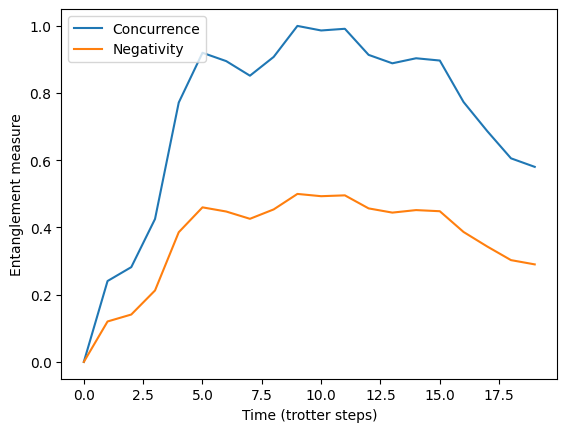

In [71]:
conc_list = concurrence(density_matrix_list)
plt.plot(range(max_trotter_steps),conc_list, label = 'Concurrence')
plt.plot(range(max_trotter_steps),neg_list, label = 'Negativity')
plt.xlabel('Time (trotter steps)')
plt.ylabel('Entanglement measure')
plt.legend(loc = 'upper left')


In [ ]:
# Let us code up the total energy for H_t

In [34]:
#Let us utilize the swap test circuit to measure the concurrence between the two leads
    
def concurrence2(qc_list):
    concurrence_list = []
    qargs = list(range(N)) + list(range(N+1,2*N+1))
    simulator_aer = AerSimulator()
    for qc in qc_list:
        qc_aer = transpile(qc, backend=simulator_aer)
        result = simulator_aer.run(qc_aer).result()

        state = result.get_statevector()
        print("Starting swap-test for state...")
        #partial_dm = partial_trace(density_matrix,qargs)
        dm_dict = swap_test_circuit(state)
        print(dm_dict)
        tr_sq = dict_to_conc(dm_dict)/1000
        print("Concurrence for state is ",np.sqrt(2*(1-tr_sq)))
        concurrence_list.append(np.sqrt(2*(1-tr_sq)))
    return concurrence_list

conc_list2 = concurrence2(qc_list)
plt.plot(range(max_trotter_steps),conc_list2, label = 'Concurrence2')
plt.plot(range(max_trotter_steps),conc_list, label = 'Concurrence')
plt.xlabel('Time (trotter steps)')
plt.ylabel('Entanglement measure')
plt.legend(loc = 'upper left')

In [53]:
#Let us create the H_t for the system
H_t = 0
theta = angles[0]
for i in range(2*N):
    if i==N-1 or i==N:
        continue
    else:
       H_t += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(2*N-i-1)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(2*N-i-1)))

print(H_t)



SparsePauliOp(['XXIIIIIIIII', 'YYIIIIIIIII', 'IXXIIIIIIII', 'IYYIIIIIIII', 'IIXXIIIIIII', 'IIYYIIIIIII', 'IIIXXIIIIII', 'IIIYYIIIIII', 'IIIIIIXXIII', 'IIIIIIYYIII', 'IIIIIIIXXII', 'IIIIIIIYYII', 'IIIIIIIIXXI', 'IIIIIIIIYYI', 'IIIIIIIIIXX', 'IIIIIIIIIYY'],
              coeffs=[-0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j,
 -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j,
 -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j,
 -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j])


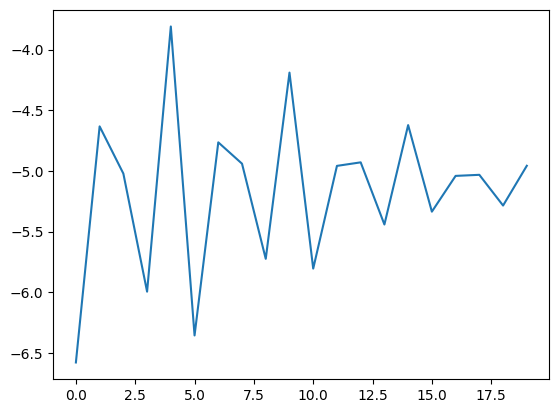

In [54]:
estimator = Estimator(approximation=True)

ham_array = [H_t]*max_trotter_steps
job_5 = estimator.run(qc_list,ham_array,shots = None)

expectation_list_5 = list(job_5.result().values)

plt.plot(range(max_trotter_steps),expectation_list_5,label = 'H_t')